## Facial Expression Recognition using CNN

The task is to classify facial expressions into one of **7 categories** using deep learning (CNN).  
The dataset used is **FER2013** from [Kaggle](https://www.kaggle.com/datasets/msambare/fer2013), containing grayscale **48x48** pixel face images.

### Emotion Classes:
- **0** = Angry  
- **1** = Disgust  
- **2** = Fear  
- **3** = Happy  
- **4** = Sad  
- **5** = Surprise  
- **6** = Neutral


In [1]:
import os

# Clone only if repo doesn't exist yet
if not os.path.exists("facial-expression-classifier"):
    print("📥 Cloning project from GitHub...")
    !git clone https://github.com/uriamedalia/facial-expression-classifier.git
else:
    print("✅ Repo already exists, skipping clone.")

# Change working directory
%cd facial-expression-classifier/src

# Install dependencies
!pip install -q torch torchvision pandas numpy matplotlib seaborn scikit-learn pillow

# Check dataset structure
train_path = "../data/train"
test_path = "../data/test"

print("✅ Train classes:", os.listdir(train_path))
print("✅ Test classes:", os.listdir(test_path))


📥 Cloning project from GitHub...
Cloning into 'facial-expression-classifier'...
remote: Enumerating objects: 34175, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 34175 (delta 27), reused 116 (delta 27), pack-reused 34058 (from 1)
Receiving objects: 100% (34175/34175), 66.87 MiB | 34.94 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (35893/35893), done.
/content/facial-expression-classifier/src
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder

# Utils
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix


This is a multi-class classification problem. We will use Convolutional Neural Networks (CNN) to learn spatial features from the face images and predict one of the 7 emotions.



In [3]:
# Define image transformations for training and testing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # FER2013 is grayscale
    transforms.Resize((48, 48)),                  # just in case
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))          # normalize to [-1, 1]
])

# Define paths
train_dir = './../data/train'
test_dir = './../data/test'

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Map class indices to emotion names
emotion_labels = train_dataset.classes
print("Emotion labels:", emotion_labels)

Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


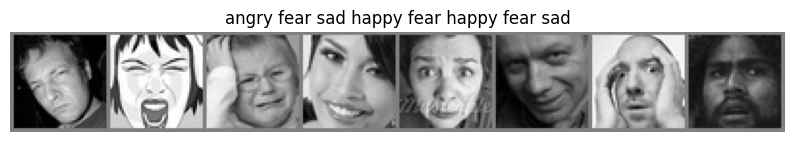

In [4]:

# Function to unnormalize image
def imshow(img, title):
    img = img * 0.5 + 0.5  # unnormalize from [-1,1] to [0,1]
    npimg = img.numpy()
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and their corresponding labels
imshow(utils.make_grid(images[:8], nrow=8),
       title=' '.join(emotion_labels[labels[j]] for j in range(8)))


In [5]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Convert input layer to accept grayscale (1 channel instead of 3)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the final layer to output 7 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

print("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


cuda


In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(test_dataset)
    val_acc = val_corrects.double() / len(test_dataset)
    print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("✅ Best model saved.")


Epoch 1/10
Train Loss: 1.5673 Acc: 0.3960
Val   Loss: 1.4288 Acc: 0.4694
✅ Best model saved.
Epoch 2/10
Train Loss: 1.2998 Acc: 0.5108
Val   Loss: 1.2593 Acc: 0.5267
✅ Best model saved.
Epoch 3/10
Train Loss: 1.1559 Acc: 0.5697
Val   Loss: 1.2421 Acc: 0.5425
✅ Best model saved.
Epoch 4/10
Train Loss: 1.0512 Acc: 0.6093
Val   Loss: 1.1709 Acc: 0.5660
✅ Best model saved.
Epoch 5/10
Train Loss: 0.9481 Acc: 0.6481
Val   Loss: 1.2341 Acc: 0.5581
Epoch 6/10
Train Loss: 0.8307 Acc: 0.6959
Val   Loss: 1.3007 Acc: 0.5644
Epoch 7/10
Train Loss: 0.7171 Acc: 0.7426
Val   Loss: 1.2452 Acc: 0.5913
✅ Best model saved.
Epoch 8/10
Train Loss: 0.5695 Acc: 0.7939
Val   Loss: 1.2923 Acc: 0.5854
Epoch 9/10
Train Loss: 0.4514 Acc: 0.8407
Val   Loss: 1.4080 Acc: 0.5822
Epoch 10/10
Train Loss: 0.3504 Acc: 0.8779
Val   Loss: 1.5001 Acc: 0.5862
